# Lesson3

- [Wiki](http://wiki.fast.ai/index.php/Lesson_3)
- [Deep Visualization Toolbox](https://github.com/yosinski/deep-visualization-toolbox)

# Dropoutの除去によるUnderfit対策

- training accuracyがvalidation accuracyよりも小さかったらunderfittingを疑う

1. vgg finetuned モデルの重みをロードする
2. conv layersとfc layersに分ける
    - vggはconv layersにdropoutを持たないため
3. fc layersからdropoutを除去する
    - dropoutの引数を0にする
    - 2倍の重みがアクティブになるので、元の重みを1/2にしてセットする
4. conv layersだけを使って推論する
5. その特徴量を使って、dropoutを除去したfc layersを学習する

In [7]:
import time
import os

import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms, datasets
torch.set_printoptions(precision=4, linewidth=100)

## 1. finetunedモデルをロード

In [46]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [47]:
# 置き換える層以外は再学習しないようにする
for param in vgg16.features.parameters():
    param.requires_grad = False

In [48]:
num_features = vgg16.classifier[6].in_features
modules = list(vgg16.classifier.children())
modules.pop()
modules.append(torch.nn.Linear(num_features, 2))
new_classifier = torch.nn.Sequential(*modules)
vgg16.classifier = new_classifier

In [49]:
vgg16.load_state_dict(torch.load("lesson1_finetuned.pt"))
model_finetuned = vgg16

## 2, 3 Dropoutを除去

In [50]:
modules_without_dropout = []
for module in model_finetuned.classifier.children():
    if type(module) != nn.Dropout:
        modules_without_dropout.append(module)
new_classifier = nn.Sequential(*modules_without_dropout)
model_finetuned.classifier = new_classifier

In [51]:
model_finetuned

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [52]:
# Dropoutを除去したので、それに対応して重みを半分にする
def half_weights(m):
    if type(m) == nn.Linear:
        print(m.weight)
        m.weight.data.mul_(1/2)
        print(m.weight)

In [53]:
model_finetuned.classifier.apply(half_weights)

Parameter containing:
-1.1094e-03 -2.6891e-03  2.1942e-03  ...   6.6429e-03 -4.2384e-04 -2.0694e-03
 5.1961e-03  2.0472e-03  4.6155e-03  ...  -5.3580e-03 -4.5462e-03 -1.8746e-03
-5.2747e-04  5.1788e-03  1.8400e-03  ...   6.8096e-03  4.6883e-04  9.0971e-03
                ...                   ⋱                   ...                
-7.5426e-03 -9.6441e-03 -2.5061e-03  ...  -7.9279e-03 -1.0565e-02 -3.6023e-03
-4.4378e-04  1.4222e-03 -1.8937e-03  ...   3.5541e-03  2.1086e-03  3.7892e-03
 6.2846e-03  4.1432e-03 -3.7906e-04  ...  -2.9724e-03  1.0594e-03  4.7496e-03
[torch.FloatTensor of size 4096x25088]

Parameter containing:
-5.5472e-04 -1.3445e-03  1.0971e-03  ...   3.3215e-03 -2.1192e-04 -1.0347e-03
 2.5981e-03  1.0236e-03  2.3078e-03  ...  -2.6790e-03 -2.2731e-03 -9.3729e-04
-2.6373e-04  2.5894e-03  9.2000e-04  ...   3.4048e-03  2.3441e-04  4.5485e-03
                ...                   ⋱                   ...                
-3.7713e-03 -4.8220e-03 -1.2530e-03  ...  -3.9639e-03 -5.2

Sequential (
  (0): Linear (25088 -> 4096)
  (1): ReLU (inplace)
  (2): Linear (4096 -> 4096)
  (3): ReLU (inplace)
  (4): Linear (4096 -> 2)
)

In [54]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

path = "data/dogscats/"
batch_size = 12 # バッチサイズが大きいとGPUのメモリに乗らないので注意
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
print(dataset_sizes, class_names)
use_gpu = torch.cuda.is_available()

{'train': 23000, 'valid': 2000} ['cats', 'dogs']


In [56]:
if use_gpu:
    model_finetuned = model_finetuned.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_finetuned.classifier.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [57]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] # loss.dataはsize 1 のTensorなので[0]を取る
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            # 最も良いモデルの重みを変数に保持
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [59]:
model_without_dropout = train_model(model_finetuned, criterion, optimizer, exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
train Loss: 0.0082 Acc: 0.9595
valid Loss: 0.0025 Acc: 0.9890

Epoch 1/2
----------
train Loss: 0.0070 Acc: 0.9648
valid Loss: 0.0022 Acc: 0.9895

Epoch 2/2
----------
train Loss: 0.0067 Acc: 0.9662
valid Loss: 0.0022 Acc: 0.9910

Training complete in 31m 41s
Best val Acc: 0.991000


# Data augmentation

直感的には、データとして含まれていてもおかしくないような加工をすれば良い

- torchvision.transforms.RandomHorizontalFlip
- torchvision.transforms.RandomRotation
  - Pytorch 0.4から登場

In [60]:
%matplotlib inline

In [63]:
path = "data/dogscats/sample/"

In [66]:
# http://pytorch.org/docs/master/torchvision/transforms.html
data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224), # 画像のサイズを合わせ、その値はpretrainedモデルに合わせる
        transforms.RandomHorizontalFlip()
    ])
dataset = datasets.ImageFolder(root=path+"train", transform=data_transform)

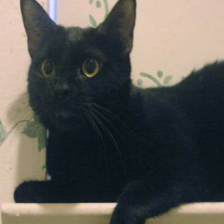

In [67]:
dataset[0][0]

## Batch normalization

all modern networks should use batchnorm, or something equivalent

1. Adding batchnorm to a model can result in 10x or more improvements in training speed
2. Because normalization greatly reduces the ability of a small number of outlying inputs to over-influence the training, it also tends to reduce overfitting.

- VGGはBatch normalizationを使っていないので、足した場合はすべての重みを最初からImageNetで学習する必要がある
  - その後、dog/cat分類用にtransfer learningを行う
- torch.nn.BatchNorm1dを使用する  